In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
! pip install rasterio
! pip install geopandas 
! pip install pyarrow
! pip install matplotlib
! pip install albumentations
!pip install pytorch-lightning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 21.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 26.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 16.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 19.0 MB/s eta 0:00:0000:0100:01
ERROR: unknown command "instalml" - maybe you meant "install"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB

In [14]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


import gc
import albumentations as album
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from albumentations import Compose
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from typing import Dict, Union, Optional, List
import pytorch_lightning as pl
import torch
import torchvision
from torch import nn, optim


In [3]:
update_storage_access()
environment = get_environment()
root_path = get_root_path()
bucket = environment["bucket"]
path_s3_s2looking = environment["sources"]["PAPERS"]["S2Looking"]
path_local_s2looking = environment["local-path"]["PAPERS"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

In [4]:
path_local_s2looking
#root_path

'data/paper_dataset'

In [17]:
fs.download(
        rpath=f"{bucket}/{path_s3_s2looking}",
        lpath=f"../{path_local_s2looking}",
        recursive=True)


In [ ]:
import zipfile
with zipfile.ZipFile(f"../{path_local_s2looking}/S2Looking.zip", 'r') as zip_ref:
    zip_ref.extractall(f"../{path_local_s2looking}")

### Go Pytorch Lightning ! 
Le but  que je me fixe ici est de réutiliser la logique de Tom jusqU40 ENTRAÏNEMENT AVE CpYTRCH lIGHTNING
Ici je vais sanctuariser l'approche par chemin de fichier où je charge une image et je sélectionne une seule aléatoirement dans l'ensemble ?
METTRE EN OPALCE DES METRIQUE SPOUR mlflow t& score etc;;

In [5]:
train_path = f"../{path_local_s2looking}/S2Looking/train/"
list_name = sorted(os.listdir(os.path.join(train_path,"Image1")))
list_path_image1 =  [ os.path.join(train_path,"Image1/")+ name for name  in list_name]
list_path_image2 =  [ os.path.join(train_path,"Image2/")+ name for name  in list_name]
list_path_label =  [ os.path.join(train_path,"label/")+ name for name  in list_name]

In [6]:
import change_detection_triplet
idx = 34
pthimg1 = list_path_image1[idx]
pthimg2 = list_path_image2[idx]
pthlabel = list_path_label[idx]


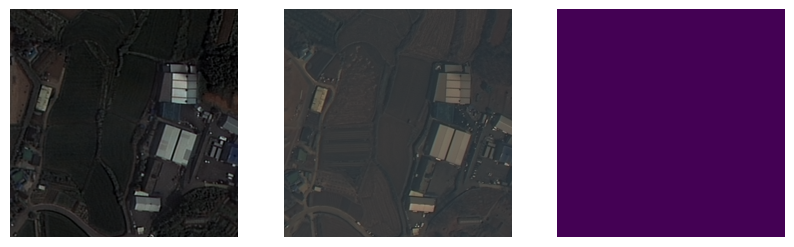

In [15]:
from change_detection_triplet import ChangedetectionTripletS2Looking
cdtriplet = ChangedetectionTripletS2Looking(pthimg1,pthimg2,pthlabel)
cdtriplet.random_crop(512)
cdtriplet.plot()

#.plot()

- Fonction de découpage aléatoire dans utils d'une image Pil (taille 250) ? regarder le crop aléatoire de l'autre notebook, l'intégrer dans la classe Dataset.
- Entraîner le Unet++ ?
- créer cette classe plutôt pour l'évaluation quali du réseau  
- créer une classe triplet Satellites Images 
- (finalement ces classes sont plus utiles pour représenter et garder l'info géo ?)
- fontion  

In [16]:
# création d'une classe Data set pour chopper les images
class ChangeDetectionS2LookingDataset(Dataset):
    """
    Custom Dataset class.
    """
    def __init__(
        self,
        list_paths_image1: List,
        list_paths_image2: List,
        list_paths_labels: List,
        transforms: Optional[Compose] = None
    ):
        """
        Constructor.

        Args:
            list_paths_image1 (List): list of path of the before state pictures
            list_paths_image2 (List): list of paths containing  the "after" state pictures
            list_paths_labels (List): list of paths containing the labeled differences (mostly segmentation masque showing the differencer between image 1 and image 2) 
        """
        self.list_paths_image1 = list_paths_image1
        self.list_paths_image2 = list_paths_image2
        self.list_paths_labels = list_paths_labels    
        self.transforms = transforms
        
        

    def __getitem__(self, idx):
        """_summary_

        Args:
            idx (_type_): _description_

        Returns:
            _type_: _description_
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        pathim1 = self.list_paths_image1[idx]
        pathim2 = self.list_paths_image2[idx]
        pathlabel = self.list_paths_labels[idx]
        
        label = 0
        compteur = 0
        while(np.max(label) == 0 and compteur < 15):
            cdtriplet = ChangedetectionTripletS2Looking(pthimg1,pthimg2,pthlabel)
            cdtriplet.random_crop(256)
            label = np.array(cdtriplet.label)
            label[label!=0] = 1
            compteur += 1
        
        #img1 = np.transpose(np.array(cdtriplet.image1),(2,0,1))
        #img2 = np.transpose(np.array(cdtriplet.image2),(2,0,1))
        
        img1 = np.array(cdtriplet.image1)
        img2 = np.array(cdtriplet.image2)
        
        #print(img1.shape)
        
        
        if self.transforms:
            sample = self.transforms(image = img1, image2 = img2, mask = label)
            img1 = sample['image']
            img2 = sample['image2']
            label = sample['mask']
        else:
            img1 = torch.tensor(np.transpose(img1,(2,0,1)))
            img2 = torch.tensor(np.transpose(img2,(2,0,1)))
        
        img_double =torch.concatenate([img1,img2],axis = 0).squeeze()
        
        img_double = img_double.type(torch.float)
        label = label.type(torch.LongTensor)
        
        return {"image" : img_double, "label" : label , "pathim1" : pathim1, "pathim2" : pathim2, "pathlabel" : pathlabel }
      
    def __len__(self):
        return len(self.list_paths_image1)



### Test dataset

In [17]:

train_path = f"../{path_local_s2looking}/S2Looking/train/"
list_name = sorted(os.listdir(os.path.join(train_path,"Image1")))
train_path_image1 =  [ os.path.join(train_path,"Image1/")+ name for name  in list_name]
train_path_image2 =  [ os.path.join(train_path,"Image2/")+ name for name  in list_name]
train_path_label =  [ os.path.join(train_path,"label/")+ name for name  in list_name]

image_size = (256,256)
transforms = album.Compose(
        [
            album.Resize(300, 300, always_apply=True),
            album.RandomResizedCrop(
                *image_size, scale=(0.7, 1.0), ratio=(0.7, 1)
            ),
            album.HorizontalFlip(),
            album.VerticalFlip(),
            album.Normalize(),
            ToTensorV2(),
       ],
        additional_targets={'image2': 'image'}
    )
 
ds = ChangeDetectionS2LookingDataset(
        train_path_image1,
        train_path_image2,
        train_path_label,
        transforms
 )

next(iter(ds))["image"].shape

torch.Size([6, 256, 256])

In [18]:

class S2LookingDataModule(pl.LightningDataModule):
    """
    Pytorch Lightning Data Module.
    """

    def __init__(
        self,
        train_data: List[str],
        valid_data: List[str],
        test_data:  List[str],
        transforms_preprocessing: Optional[Compose] = None,
        transforms_augmentation: Optional[Compose] = None,
        batch_size: int = 20,
        num_workers: int = 4
    ):
        """
        Data Module constructor.

        Args:
            train_data (List): List of training (and validation) instances
            test_data (List): List of test instances
            transforms_preprocessing (Optional[Compose]): Compose object
                from albumentations applied on validation and test datasets.
            transforms_augmentation (Optional[Compose]): Compose object
                from albumentations applied on training dataset.
            batch_size (int): Batch size.
            num_workers (int): Number of workers to process data.
            bands_indices (List): List of indices of bands to plot.
                The indices should be integers between 0 and the
                number of bands - 1.
        """
        super().__init__()

        self.train_data = train_data # list containing image1 path, imaghe 2 paths and label paths
        self.valid_data = valid_data
        self.test_data = test_data
        self.transforms_preprocessing = transforms_preprocessing
        self.transforms_augmentation = transforms_augmentation
        #self.transforms_preprocessing = False
        #self.transforms_augmentation = False
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.setup()

    def setup(self, stage: str = None) -> None:
        """
        Start training, validation and test datasets.

        Args:
            stage (Optional[str]): Used to separate setup logic
                for trainer.fit and trainer.test.
        """
        n_samples = len(self.train_data[0])
        
        self.dataset_train = ChangeDetectionS2LookingDataset(
            self.train_data[0],
            self.train_data[1],
            self.train_data[2],
            transforms=self.transforms_augmentation,
        )
            
            
         
        self.dataset_val = ChangeDetectionS2LookingDataset(
            self.valid_data[0],
            self.valid_data[1],
            self.valid_data[2],
            transforms=self.transforms_preprocessing
        )
        
        self.dataset_test = ChangeDetectionS2LookingDataset(
            self.test_data[0],
            self.test_data[1],
            self.test_data[2],
            transforms=self.transforms_preprocessing
        )

    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        """
        Create Dataloader.
        Returns: DataLoader
        """
        return DataLoader(
            self.dataset_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self, *args, **kwargs) -> DataLoader:
        """
        Create Dataloader.
        Returns: DataLoader
        """
        return DataLoader(
            self.dataset_val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def test_dataloader(self, *args, **kwargs) -> DataLoader:
        """Create Dataloader.
        Returns: DataLoader
        """
        return DataLoader(
            self.dataset_test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )


### test du S2Looking Data Module

## Le modèle et l'Opti

In [24]:


class DeepLabv3Module(nn.Module):
    """ """

    def __init__(self):
        """ """
        super().__init__()
        self.model = torchvision.models.segmentation.deeplabv3_resnet101(
            weights="DeepLabV3_ResNet101_Weights.DEFAULT"
        )
        # 1 classe !
        self.model.classifier[4] = nn.Conv2d(
            256, 2, kernel_size=(1, 1), stride=(1, 1)
        )
        self.model.backbone["conv1"] = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding = (3,3), bias = False)

    def forward(self, x):
        """ """
        return self.model(x)["out"]


class DeepLabv3LitModule(pl.LightningModule):
    """
    Pytorch Lightning Module for DeepLabv3.
    """

    def __init__(
        self,
        model: DeepLabv3Module,
        optimizer: Union[optim.SGD, optim.Adam],
        optimizer_params: Dict,
        scheduler: Union[
            optim.lr_scheduler.OneCycleLR, optim.lr_scheduler.ReduceLROnPlateau
        ],
        scheduler_params: Dict,
        scheduler_interval: str,
    ):
        """
        Initialize TableNet Module.
        Args:
            model
            optimizer
            optimizer_params
            scheduler
            scheduler_params
            scheduler_interval
        """
        super().__init__()

        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optimizer
        self.optimizer_params = optimizer_params
        self.scheduler = scheduler
        self.scheduler_params = scheduler_params
        self.scheduler_interval = scheduler_interval

    def forward(self, batch):
        """
        Perform forward-pass.
        Args:
            batch (tensor): Batch of images to perform forward-pass.
        Returns (Tuple[tensor, tensor]): Table, Column prediction.
        """
        return self.model(batch)

    def training_step(self, batch, batch_idx):
        """
        Training step.
        Args:
            batch (List[Tensor]): Data for training.
            batch_idx (int): batch index.
        Returns: Tensor
        """
        samples =  batch["image"].to(self.device)
        labels = batch["label"].to(self.device)
        
        
        output = self.forward(samples)

        loss = self.loss(output, labels)
        self.log("loss", loss)
        
        tqdm_dict = {'train_loss': loss}
        outputs = {
            'loss': loss,
            'progress_bar': tqdm_dict,
            'log': tqdm_dict
        }
        del samples, labels
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step.
        Args:
            batch (List[Tensor]): Data for training.
            batch_idx (int): batch index.
        Returns: Tensor
        """
  
        
        samples =  batch["image"].to(self.device)
        labels = batch["label"].to(self.device)
        
        output = self.forward(samples)

        loss = self.loss(output, labels)
        self.log("validation_loss", loss, on_epoch=True)
        
        del samples, labels
       
        return loss

    def test_step(self, batch, batch_idx):
        """
        Test step.
        Args:
            batch (List[Tensor]): Data for training.
            batch_idx (int): batch index.
        Returns: Tensor
        """
        samples =  batch["image"].to(self.device)
        labels = batch["label"].to(self.device)
        
 
        output = self.forward(samples)["out"]

        loss = self.loss(output, labels)
        self.log("test_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        """
        Configure optimizer for pytorch lighting.
        Returns: optimizer and scheduler for pytorch lighting.
        """
        optimizer = self.optimizer(self.parameters(), **self.optimizer_params)
        scheduler = self.scheduler(optimizer, **self.scheduler_params)
        scheduler = {
            "scheduler": scheduler,
            "monitor": "validation_loss",
            "interval": self.scheduler_interval,
        }

        return [optimizer], [scheduler]


## Train time

In [23]:


torch.cuda.empty_cache()
gc.collect()

# Loading images
    # DataModule definition
    # Some additional normalization is done here
image_size = (256, 256)
transforms_augmentation = album.Compose(
        [
            album.Resize(300, 300, always_apply=True),
            album.RandomResizedCrop(
                *image_size, scale=(0.7, 1.0), ratio=(0.7, 1)
            ),
            album.HorizontalFlip(),
            album.VerticalFlip(),
            album.Normalize(),
            ToTensorV2(),
       ],
        additional_targets={'image2': 'image'}
    )


transforms_preprocessing = album.Compose(
        [
            album.Resize(*image_size, always_apply=True),
            album.Normalize(),
            ToTensorV2(),
        ],
        additional_targets={'image2': 'image'} # pour pouvoir appliquer la même transfo à 2 images pour un seul masque (cd detection)
)


train_path = f"../{path_local_s2looking}/S2Looking/train/"
list_name = sorted(os.listdir(os.path.join(train_path,"Image1")))
train_path_image1 =  [ os.path.join(train_path,"Image1/")+ name for name  in list_name]
train_path_image2 =  [ os.path.join(train_path,"Image2/")+ name for name  in list_name]
train_path_label =  [ os.path.join(train_path,"label/")+ name for name  in list_name]


valid_path = f"../{path_local_s2looking}/S2Looking/val/"
list_name = sorted(os.listdir(os.path.join(valid_path,"Image1")))
valid_path_image1 =  [ os.path.join(valid_path,"Image1/")+ name for name  in list_name]
valid_path_image2 =  [ os.path.join(valid_path,"Image2/")+ name for name  in list_name]
valid_path_label =  [ os.path.join(valid_path,"label/")+ name for name  in list_name]

test_path = f"../{path_local_s2looking}/S2Looking/test/"
list_name = sorted(os.listdir(os.path.join(test_path,"Image1")))
test_path_image1 =  [ os.path.join(test_path,"Image1/")+ name for name  in list_name]
test_path_image2 =  [ os.path.join(test_path,"Image2/")+ name for name  in list_name]
test_path_label =  [ os.path.join(test_path,"label/")+ name for name  in list_name]


# Training
optimizer = torch.optim.SGD
optimizer_params = {"lr": 0.0001, "momentum": 0.9}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {}
scheduler_interval = "epoch"

model = DeepLabv3Module()

data_module = S2LookingDataModule(
    train_data=[train_path_image1, train_path_image2, train_path_label],
    valid_data =[valid_path_image1, valid_path_image2, valid_path_label],
    test_data =[test_path_image1, test_path_image2, test_path_label],
    transforms_augmentation=transforms_augmentation,
    transforms_preprocessing=transforms_preprocessing,
    num_workers=1, # 15 coeurs déjà
    batch_size=8
)


lightning_module = DeepLabv3LitModule(
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval,
)

checkpoint_callback = ModelCheckpoint(
    monitor="validation_loss", save_top_k=1, save_last=True, mode="min"
)
early_stop_callback = EarlyStopping(
    monitor="validation_loss", mode="min", patience=3
)
lr_monitor = LearningRateMonitor(logging_interval="step")

gpus = 1
strategy = "ddp" if gpus > 1 else None
strategy ="auto"


In [13]:

trainer = pl.Trainer(
    callbacks=[lr_monitor, checkpoint_callback, early_stop_callback],
    max_epochs=100,
    num_sanity_val_steps=2,
    strategy=strategy,
    log_every_n_steps=2
)
trainer.fit(lightning_module, datamodule=data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/mamba/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | DeepLabv3Module  | 61.0 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
61.0 M    Trainable params
0         Non-tra

Sanity Checking: 0it [00:00, ?it/s]

/opt/mamba/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


NameError: Caught NameError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/mamba/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/mamba/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/mamba/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_9937/4244899239.py", line 47, in __getitem__
    cdtriplet = ChangedetectionTripletS2Looking(pthimg1,pthimg2,pthlabel)
NameError: name 'ChangedetectionTripletS2Looking' is not defined


In [19]:
# Reprendre l'entrainement 
lightning_module_checkpoint = lightning_module.load_from_checkpoint(
    checkpoint_path=trainer.checkpoint_callback.best_model_path, # je créé un module qui charge
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval
                                     )
trainer.fit(lightning_module, datamodule=data_module)


IsADirectoryError: [Errno 21] Is a directory: '/home/onyxia/work/detection-habitat-spontane/notebooks'

## Evaluation graphique

On récupère les modèles entraînés par callback

In [165]:
lightning_module_checkpoint = lightning_module.load_from_checkpoint(
    checkpoint_path=trainer.checkpoint_callback.best_model_path, # je créé un module qui charge
    model=model,
    optimizer=optimizer,
    optimizer_params=optimizer_params,
    scheduler=scheduler,
    scheduler_params=scheduler_params,
    scheduler_interval=scheduler_interval
                                     )


In [172]:
iterateur = iter(data_module.dataset_val)

/tmp/ipykernel_4656/3593824626.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample).unsqueeze(0).type(torch.float)


torch.Size([1, 2, 256, 256])
1846
tensor(1) tensor(0)


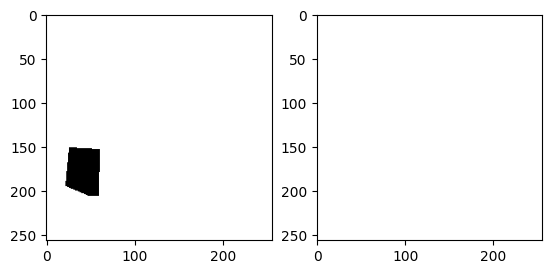

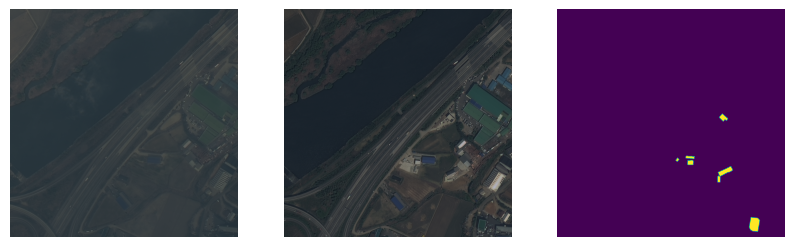

In [177]:
batch = next(iterateur)
sample = batch["image"]
label = np.array(batch["label"])
sample = torch.tensor(sample).unsqueeze(0).type(torch.float)
model = lightning_module_checkpoint.model.to("cpu")
model.eval()
res = model(sample)
print(res.shape)
mask = torch.argmax(res,axis = 1)


print(np.sum(label))
print(torch.max(batch["label"]),torch.max(mask))


#np.array(mask)
#print(np.array(batch["image"][:3]))
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(label, cmap='binary')
ax2.imshow(np.array(mask.squeeze()), cmap='binary')
plt.show()
cdtriplet = ChangedetectionTripletS2Looking(batch["pathim1"],batch["pathim2"],batch["pathlabel"])
cdtriplet.plot()


In [102]:
batch.keys()

dict_keys(['image', 'label', 'pathim1', 'pathim2', 'pathlabel'])

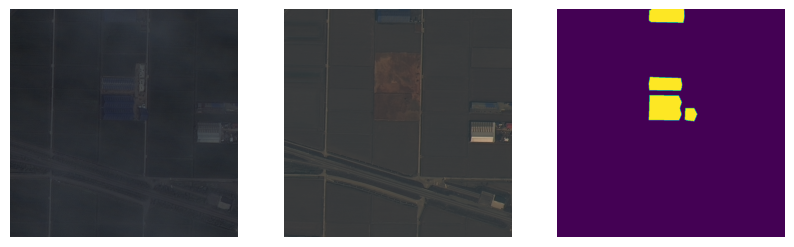

In [ ]:
# comment représenter au mieux l'image en entrée ?  gard

## Bilan 
- Comment éviter la machine à Gaz ?
- trop de patch avec 0 change  -> le modèle s'entraine à prédire rien du tout..
- forcer les exemple à contenir un bout de changement 
- Probèmes de mémoire, taille du batch etc..
- chargement par filepath avec CROP aléatoire + au moins un pixel blanc
- but représenter les images entrée et on est bon -> easy garder les liens de fichiers dan s la sortie du data set <3
